In [3]:
%reset -f
%matplotlib inline

from os import listdir
import os


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets, plotting, input_data, signal  # for fetching atlas

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

from fctools import denoise

/home/finc/anaconda/lib/python3.6/site-packages/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


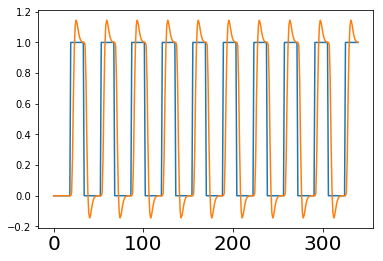

In [10]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'

events = pd.read_csv(onsets_dir)

frame_times = np.arange(n_scans) * t_r

#------ step 1
box = make_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

# ----- step 2

box_hrf = make_design_matrix(frame_times, events, hrf_model = 'spm')
box_hrf  = box_hrf.reset_index()

plt.plot(box['2-back'])
plt.plot(box_hrf['2-back'])

Calculating correlations (normal way)
------------------------------

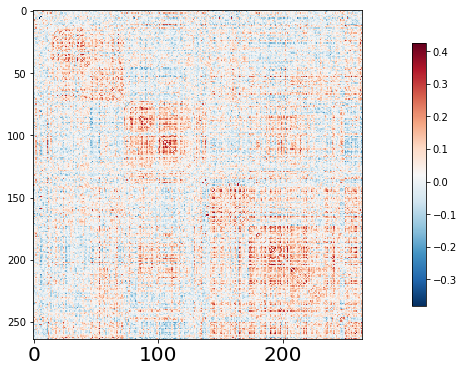

In [84]:
correlation_measure = ConnectivityMeasure(kind = 'correlation')
        
rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf['1-back']])
rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
                        
timeseries_1back = timeseries[rect_box_hrf > 0, :]
timeseries_1back = (timeseries_1back.T * rect_nnz).T

fc = correlation_measure.fit_transform([timeseries_1back])[0]
np.fill_diagonal(fc, 0)
                        
correlation_matrix = np.arctanh(fc)

plotting.plot_matrix(correlation_matrix)

Here magic happens...
============================

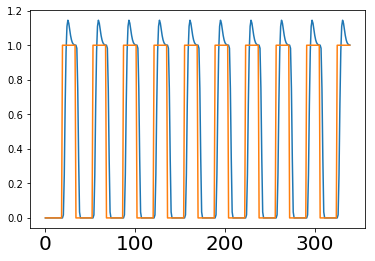

In [46]:
rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf['2-back']])
plt.plot(rect_box_hrf)
plt.plot(box['2-back'])


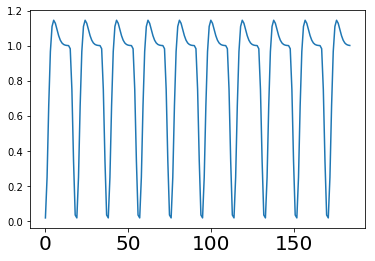

In [47]:
rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
plt.plot(rect_nnz)


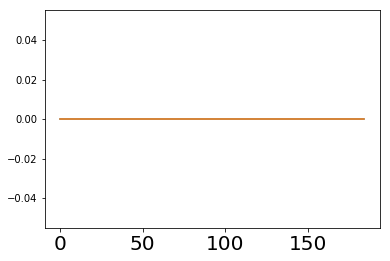

In [48]:
timeseries_all.shape

x = timeseries_all[10, 0, rect_box_hrf > 0, :]
y = x[:,1]*rect_nnz
plt.plot(x[:,1])
plt.plot(y)

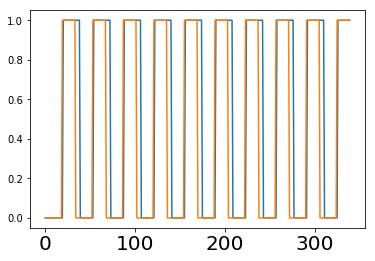

In [49]:
plt.plot(box_hrf['2-back'] > 0)
plt.plot(box['2-back'])

Calculate correlation matrices - normal way
----------------------------------------------------


In [8]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'

data1 = np.load(top_dir + 'LearningBrain_dualnback_conn_settings_12mp_no_task_effects.npy')
data2 = np.load(top_dir + 'LearningBrain_dualnback_conn_settings_12mp_task_effects.npy')
data3 = np.load(top_dir + 'LearningBrain_dualnback_conn_settings_24mp_no_task_effects.npy')
data4 = np.load(top_dir + 'LearningBrain_dualnback_conn_settings_24mp_task_effects.npy')

data1.shape

(46, 4, 340, 264)

In [38]:
data = data4

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = ['1-back', '2-back']
rois_n = len(data[0, 0, 0, :])


correlation_matrices = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(sub_n):
    for ses in range(ses_n):                 
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        
        for con in range(len(cond)):
            
            timeseries_dual = data[sub, ses, box[cond[con]].values > 0.9, :]
            
            fc = correlation_measure.fit_transform([timeseries_dual])[0]
            np.fill_diagonal(fc, 0)
                        
            correlation_matrices[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices.shape

(46, 4, 2, 264, 264)

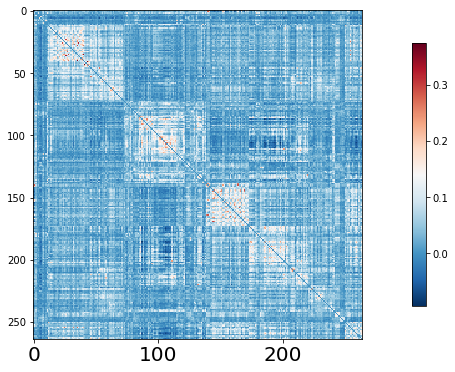

In [39]:
mean_nback_nor = correlation_matrices.mean(axis = 0)

plotting.plot_matrix(mean_nback_nor[0,0,:,:])


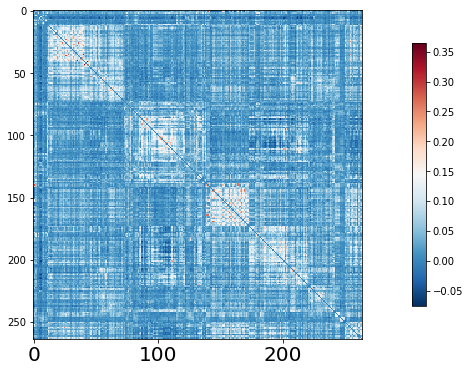

In [40]:
plotting.plot_matrix(mean_nback_nor[0,1,:,:])

Calculating correlation matricices - weighted GLM
-----------------------------------------------------

In [101]:
data = data2

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = ['1-back', '2-back']
rois_n = len(data[0, 0, 0, :])


correlation_matrices_wei = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(sub_n):
    for ses in range(ses_n):                 
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        
        for con in range(len(cond)):
            rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
            rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
                        
            timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
            
            timeseries_dual = (timeseries_dual.T * rect_nnz).T
            
            fc = correlation_measure.fit_transform([timeseries_dual])[0]
            np.fill_diagonal(fc, 0)
                        
            correlation_matrices_wei[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices_wei.shape


(46, 4, 2, 264, 264)

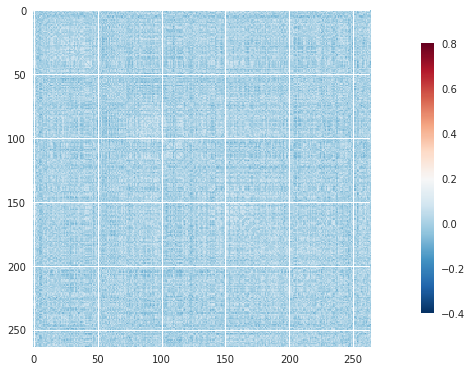

In [102]:
plotting.plot_matrix(correlation_matrices_wei[0,0,1,:,:], vmin = -0.4, vmax = 0.8)


In [46]:
mean_nback_wei = correlation_matrices_wei.mean(axis = 0)


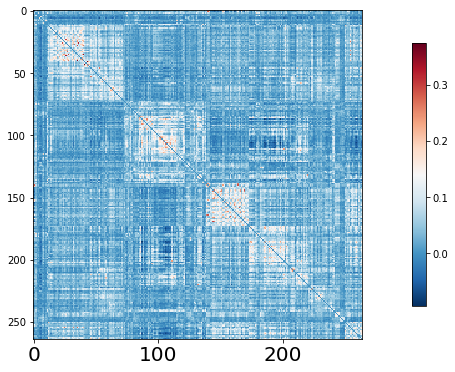

In [47]:
plotting.plot_matrix(mean_nback_nor[0,0,:,:])


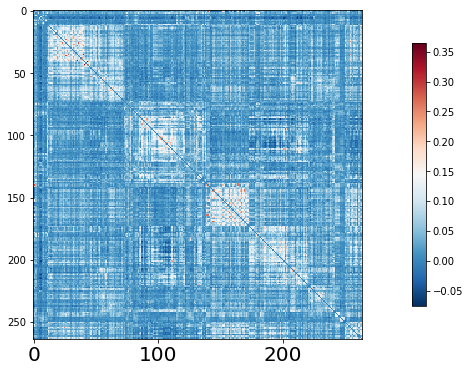

In [48]:
plotting.plot_matrix(mean_nback_nor[0,1,:,:])


In [37]:
import bct
gamma = 1

for 
[ci,Q] = bct.modularity_louvain_und_sign(mean_nback_nor[3,0,:,:], gamma)
Q

0.20845708391792539

In [69]:
from scipy import stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

one_back = sym_matrix_to_vec(correlation_matrices_wei[:,0,0,:,:], discard_diagonal = True)
two_back = sym_matrix_to_vec(correlation_matrices_wei[:,0,1,:,:], discard_diagonal = True)

stat, pvalues = stats.ttest_rel(one_back, two_back)

import statsmodels.stats.multitest as ssm

_, pvals_corrected, _, _ = ssm.multipletests(pvalues, alpha = 0.1, method = 'fdr_bh')

pvals_corrected_thr = np.zeros((len(pvals_corrected)))

pvals = np.array([0 if p >= 0.05 else 1 for p in pvals_corrected])
sum(pvals)

0

In [82]:
x = pvalues < 0.001

In [85]:
x = x.astype('float')

In [87]:
sum(x)

113.0

In [88]:
diag = np.zeros((264))

matrix_bin = vec_to_sym_matrix(x, diagonal = diag)



In [93]:
from fctools import networks

modules = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/code/modules.txt', sep = " ", header = None)
lsn = modules[0].values
labels = np.unique(lsn)
networks = networks.calculate_lsn_edges(matrix_bin, lsn)

Text(0.5,1,'2-back > 0-back')

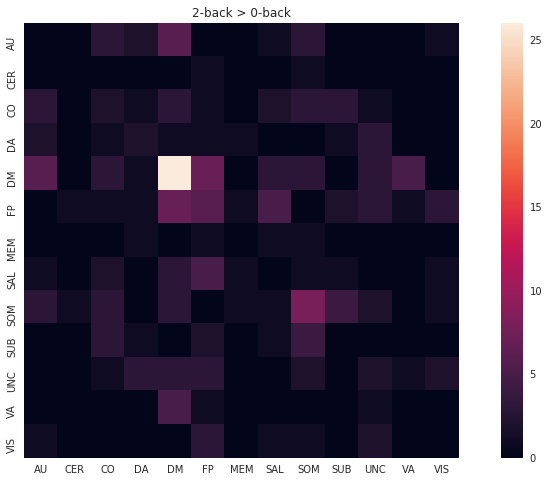

In [94]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,8))
sns.heatmap(networks, yticklabels = labels, xticklabels = labels, square = True).set_title('2-back > 0-back')

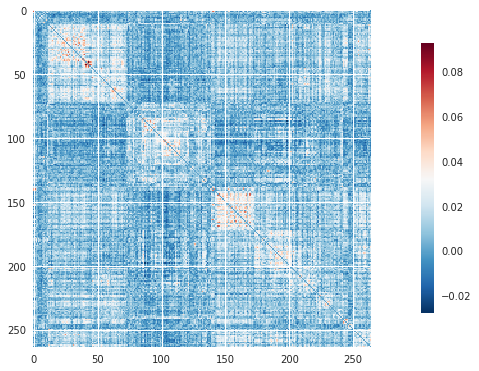

In [115]:
b = correlation_matrices_wei.mean(axis = 0)

plotting.plot_matrix(b[0,1,:,:])

In [109]:
correlation_matrices_wei.shape

(46, 4, 2, 264, 264)

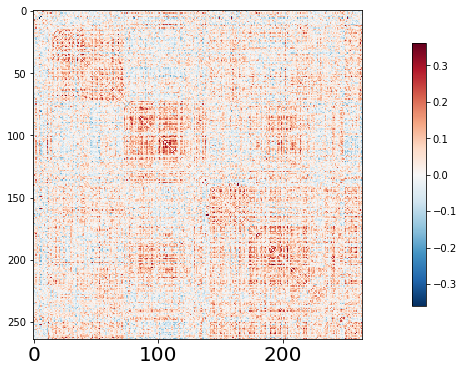

In [46]:
plotting.plot_matrix(correlation_matrices_wei[4, 0, 0, :, :])


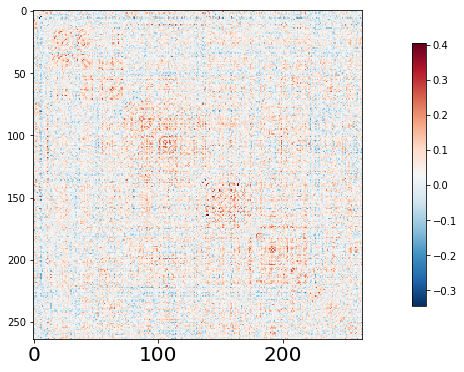

Neurostars post
----------------------

In [104]:
fc = correlation_measure.fit_transform([data2[0,0,:,:]])[0]
np.fill_diagonal(fc, 0)
                        
correlation_matrix = np.arctanh(fc)

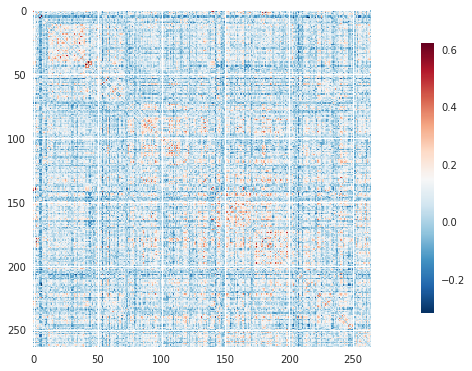

In [106]:
plotting.plot_matrix(correlation_matrix)

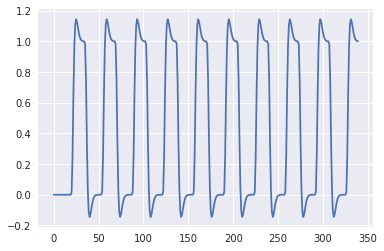

In [116]:
plt.plot(box_hrf['2-back'])

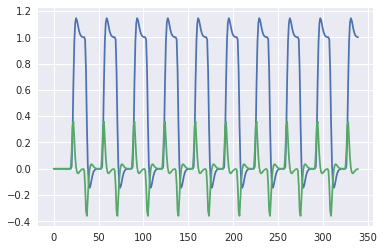

In [125]:
from scipy.misc import derivative
plt.plot(box_hrf['2-back'])
plt.plot(np.gradient(box_hrf['2-back']))


In [134]:
box_hrf['2-back'][70]

0.75080634678057634

In [133]:
np.gradient(box_hrf['2-back'])[70]

-0.32010816088932587

In [121]:
np.array(box_hrf['2-back'])

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.75784646e-02,
         2.49193653e-01,   6.57794786e-01,   9.65790272e-01,
         1.10914579e+00,   1.14470784e+00,   1.12751356e+00,
         1.09175297e+00,   1.05680421e+00,   1.03098254e+00,
         1.01511699e+00,   1.00666180e+00,   1.00265065e+00,
         1.00092500e+00,   1.00024215e+00,   9.82421535e-01,
         7.50806347e-01,   3.42205214e-01,   3.42097278e-02,
        -1.09145785e-01,  -1.44707837e-01,  -1.27513560e-01,
        -9.17529676e-02,  -5.68042082e-02,  -3.09825380e-02,
        -1.51169919e-02,  -6.66179684e-03,  -2.65064673e-03,
        -9.25002319e-04,